In [1]:
import numpy as np
from random import choice
from PIL import Image
import keras
from matplotlib.pyplot import imshow
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from glob import glob
import sys
sys.path.append('..')
import condense

model = ResNet50(weights='imagenet')
pruned = condense.one_shot(model, .0001)
DATA = '/Users/lucas/Dropbox/FH-Landshut Courses/Bachelor Arbeit/resources/datasets/imagenet/'

print(f'Unpruned: {condense.utils.model_utils.calc_model_sparsity(model)}')
print(f'Pruned: {condense.utils.model_utils.calc_model_sparsity(pruned)}')

Unpruned: 0.0010335178707784368
Pruned: 0.001123115944041504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


644 0.99998593 644
644 0.99998593 644


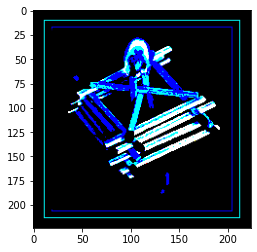

In [2]:
def test_data_generator():
    while True:
        label = choice(glob(f'{DATA}*/')).split('/')[-2]
        im = Image.open(choice(glob(f'{DATA}/{label}/*')))
        im = im.resize((224,224))
        im = preprocess_input(np.asarray(im))
        y = np.zeros((1,1000))
        y[0, int(label)] = 1.0
        yield np.array([im]), y.reshape((1, 1000))

gen = test_data_generator()
im, label = next(gen)
imshow(im[0])
x = model.predict(np.array(im))
x_pruned = pruned.predict(im)
print(np.argmax(x), np.max(x), np.argmax(label))
print(np.argmax(x_pruned), np.max(x_pruned), np.argmax(label))

In [3]:
model.compile('adam', 'categorical_crossentropy')
base_eval = model.evaluate(gen, steps=200, verbose=0)
print(f'Base Loss: {base_eval}')

Base Loss: 1.0170140266418457


In [4]:
pruned = condense.keras.wrap_model(model, condense.optimizer.sparsity_functions.Constant(0.3))
pruned.compile('adam', 'categorical_crossentropy')
pruned.fit(gen, epochs=1, steps_per_epoch=1, callbacks=[condense.keras.PruningCallback()])

1/1 [==============================] - 7s 7s/step - loss: 6.1830


In [5]:
pruned_eval = pruned.evaluate(gen, steps=200, verbose=0)

print(f'Pruned Evaluation Loss: {pruned_eval}')
print(f'Delta: {abs(pruned_eval - base_eval)}')

Pruned Evaluation Loss: 1.7179803848266602
Delta: 0.7009663581848145


816 0.4006098 816


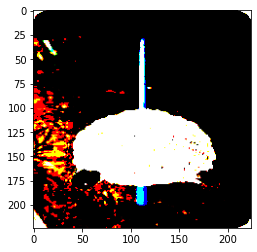

In [13]:
gen = test_data_generator()
im, label = next(gen)
imshow(im[0])
x = model.predict(np.array(im))
x_pruned = pruned.predict(im)
print(np.argmax(x), np.max(x), np.argmax(label))